In [1]:
%matplotlib inline
from scipy.io import wavfile 
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft , ifft

In [2]:
fs, data = wavfile.read('1.wav') # 音频数据导入
audioData = [(ele/2**16.) for ele in data]
lengthAudio = len(audioData)
alpha = 0.97

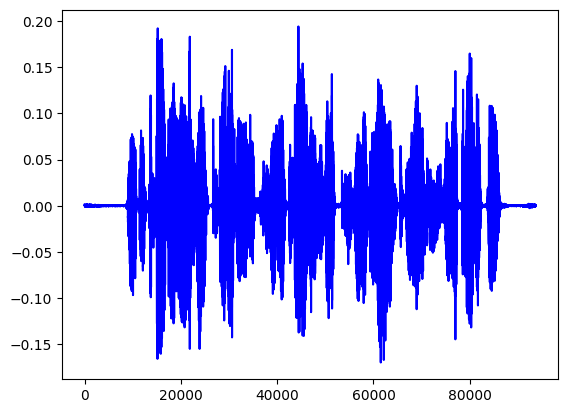

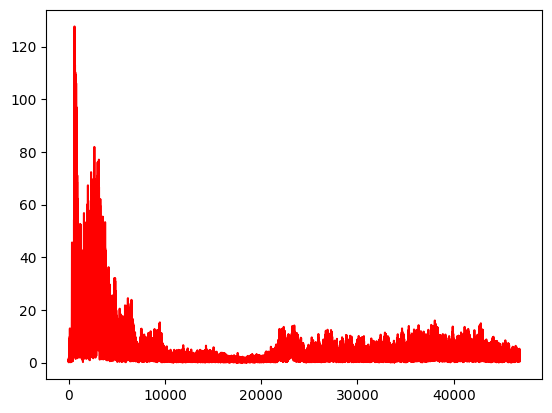

In [3]:
audioDataFFT = fft(audioData)
plt.plot(audioData,'b')
plt.show()
plt.plot(abs(audioDataFFT[:int(lengthAudio/2-1)]),'r')
plt.show()

(93679,)


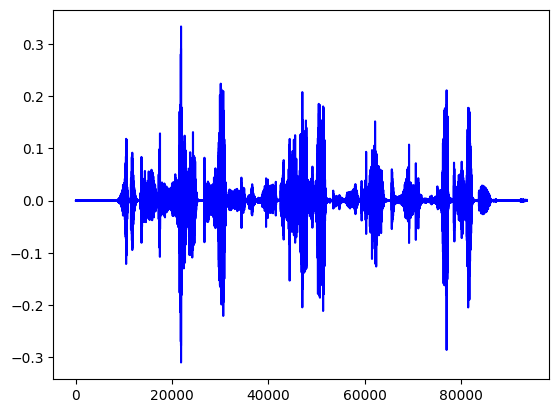

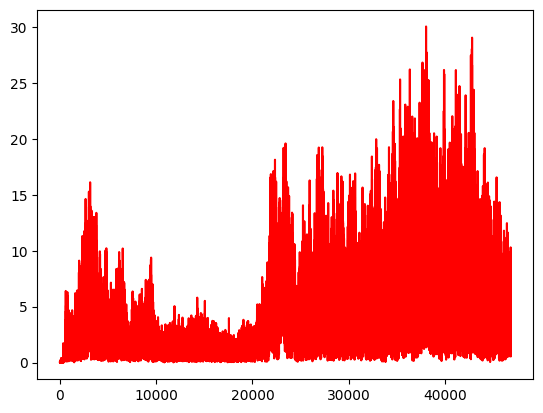

In [4]:
dataPreEmphasis = [audioData[ii]-alpha * audioData[ii-1] for ii in range(1,lengthAudio)]
print(np.shape(dataPreEmphasis))
dataPreEmphasis.append(audioData[0])
dataPreEmphasisFFT = fft(dataPreEmphasis)
plt.plot(dataPreEmphasis,'b')
plt.show()
plt.plot(abs(dataPreEmphasisFFT[:int(lengthAudio/2-1)]),'r')
plt.show()

In [5]:
# Framing 成帧
audioList = list()

frameLen = int(fs*0.025) # 帧长为 25ms
gapLen  = int(fs * 0.01)
print(frameLen,gapLen)
print(np.shape(dataPreEmphasis))
print(np.shape(dataPreEmphasis[583*gapLen:583*gapLen + frameLen]))
audioList = [dataPreEmphasis[ii*gapLen:ii*gapLen + frameLen] for ii in range(1+int((lengthAudio-frameLen)/gapLen))]


400 160
(93680,)
(400,)


In [6]:
print((lengthAudio-frameLen)/gapLen)

583.0


(400,)


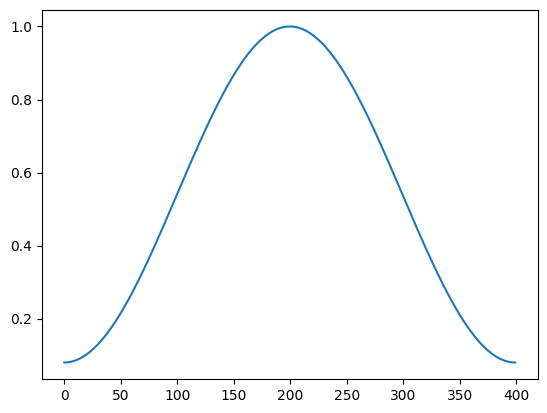

(584, 400)


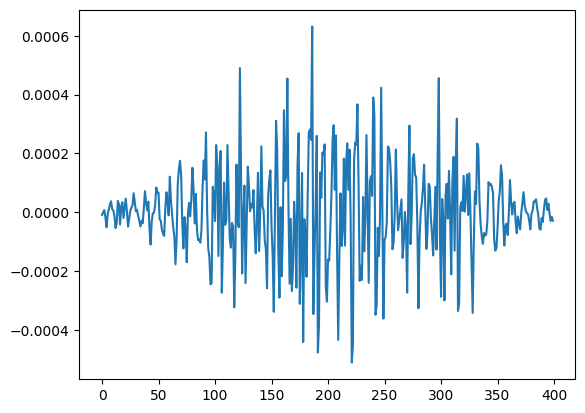

In [7]:
# Window 加窗
w = [0.54 - 0.46 * np.cos(2*np.pi*ii/(frameLen-1)) for ii in range(frameLen)]
print(np.shape(w))
plt.plot(w)
plt.show()
for ii in range(len(audioList)):
    if len(audioList[ii]) != len(w):
        print(ii)
dataWindowed = [np.array(audioList[ii]) * np.array(w) for ii in range(len(audioList))]
print(np.shape(dataWindowed))
plt.plot(dataWindowed[0])
plt.show()

(584, 512)


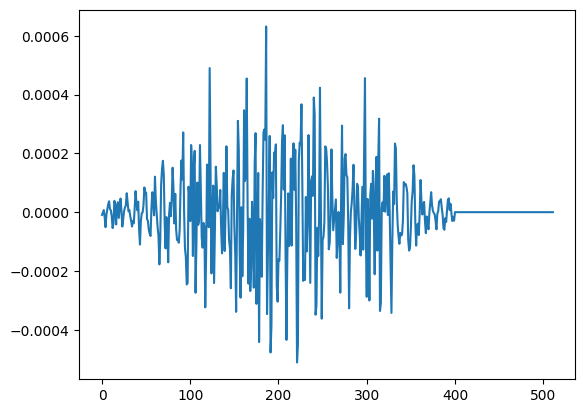

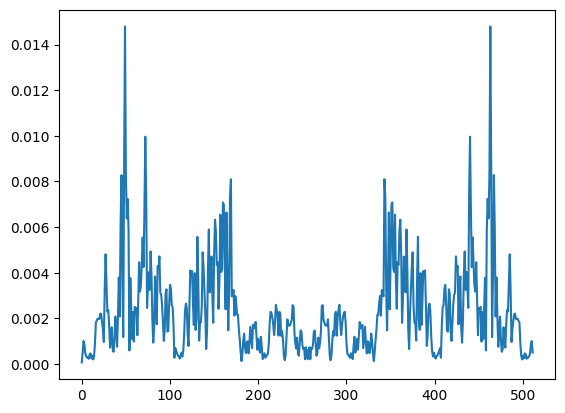

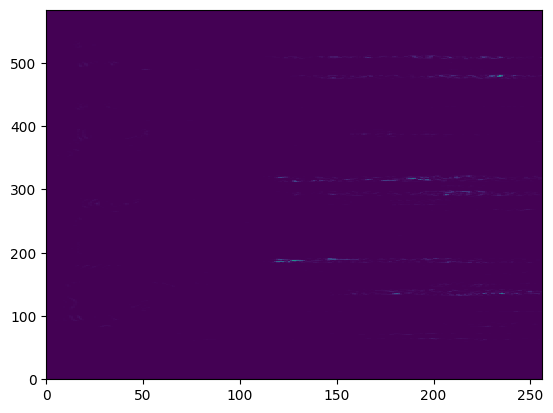

In [8]:
# Fourier-Transform and Power Spectrum
dataPad512 = np.pad(dataWindowed,((0,0),(0,512-np.shape(dataWindowed)[1])),'constant')
print(np.shape(dataPad512))
plt.plot(dataPad512[0])
plt.show()
dataFFT512 = fft(dataPad512)
PowerFFT512 = np.power(abs(dataFFT512),2)/512
PowerFFT512 = PowerFFT512[:,:256]
plt.plot(abs(dataFFT512[0,:512]))
plt.show()
plt.pcolor(PowerFFT512)
plt.show()

[   0.     31.25   93.75  156.25  187.5   250.    312.5   375.    437.5
  531.25  593.75  687.5   750.    843.75  968.75 1062.5  1156.25 1281.25
 1406.25 1562.5  1687.5  1843.75 2000.   2187.5  2375.   2562.5  2750.
 2968.75 3218.75 3468.75 3718.75 4000.   4312.5  4625.   4968.75 5312.5
 5687.5  6093.75 6531.25 7000.   7468.75 8000.  ]


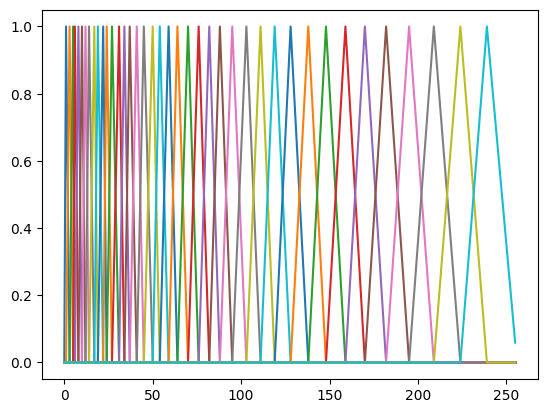

In [9]:
# Filter Bank
def getMelFilterList(MelFilterN):
    MMax = 2595 * np.log10(1+fs/1400)
    MelStep = MMax/41
    MelFrequenceList = [700*(10**(ii*MelStep/2595)-1) for ii in range(42)]
    MelFilterList = list()
    fStep = fs/2/MelFilterN
    # 可以比较得到将 Mel-frequence 移动到最近的频率 会更好
    MelFrequenceList = np.rint(np.array(MelFrequenceList)/fStep)*fStep
    print(MelFrequenceList)
    for ii in range(40):
        filter = list()
        for fn in range(MelFilterN):
            if fStep * fn < MelFrequenceList[ii] or fStep * fn > MelFrequenceList[ii+2]:
                filter.append(0)
            elif fStep * fn < MelFrequenceList[ii+1]:
                filter.append((fStep * fn - MelFrequenceList[ii])/(MelFrequenceList[ii+1] - MelFrequenceList[ii]))
            else:
                filter.append((- fStep * fn + MelFrequenceList[ii+2])/(MelFrequenceList[ii+2] - MelFrequenceList[ii+1]))
        MelFilterList.append(filter)
    return MelFilterList
MelFilterList512 = getMelFilterList(256)
[plt.plot(MelFilterList512[ii]) for ii in range(40)]
plt.show()


In [10]:
fBank = np.array([MelFilterList512[ii] * PowerFFT512 + 1e-10 for ii in range(40)]) # 1e-10 防止过小溢出
fBank = np.sum(fBank,axis = 2)
fM = 10 * np.log10(fBank)
print(np.shape(fM))

(40, 584)


(13, 584)


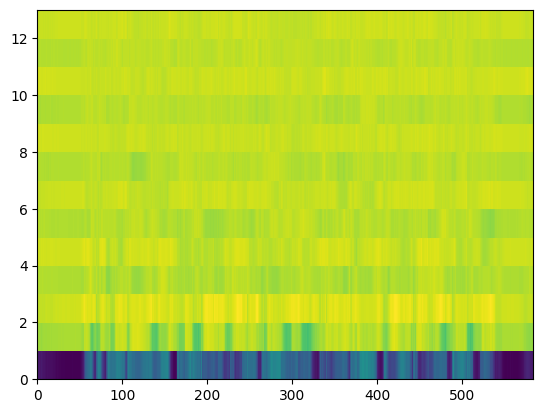

In [11]:
fMShape = np.shape(fM)
cepCeoff = np.zeros([13,fMShape[1]])
cosList = np.zeros([13,40,1])
for ii in range(13):
    for jj in range(40):
        cosList[ii,jj,0] = np.cos(np.pi * ii * (jj - 0.5)/40)
cepCeoff = np.sum(fM*cosList,axis = 1)
print(np.shape(cepCeoff))
# [plt.plot(cepCeoff[ii]) for ii in range(13)] 
plt.pcolor(cepCeoff)
plt.show()
